# Homework 2
Zach Bogart, Josh Feldman

- In this homework, we are trying to create movie recommendations for users based on the MovieLens dataset. We want to create recommendations that are relevant to the users, giving new movies thay have not seen, but might enjoy since other users with similar watch patterns have rated them highly.
- We explored two models of collaborative filtering: one model-based and one neighborhood-based. We used non-negative matrix factorization (model-based) and k-nearest neighbors (neighborhood-based). We are interested in seeing how the models differ in accuracy metrics and what sacrifices may have to be made to achieve those results.
- For our accuracy metrics, we used root mean squared error and mean absolute error. We used both of these metrics because they weighted outliers differently, giving a different sense of how accurate our results are. RMSE weights outliers more heavily. We chose RMSE as our primary accuracy metric.



## Our Process (the python script)

- To test the ability of the model to give good predictions to users, we needed to get the best parameters for the model. To do this, we did cross validation using gridSearchCV to test the effect different hyperparameters had on the model. We split the cross validation into separate grid searches since the models take a long time to run (due to the size of the dataset). 
- After grid search, we save off the best parameters.
- With the best parameters, we systematically tested how the size of the training data affected results, collecting accuracy metrics and runtime figures.
- Finally, we used the best hyperparameters to train the models and evaluate them on the test data. We then saved off these models to be used to make recommendations.

- With this, we have a setup where we can pass in a model, cross-validate the desired hyperparameters, and report accuracy metrics based on those choices to find the best setup. Below we will show the results.

- **NOTE**: This notebook expects the results of the script. We saved off the results to be used. However, you can run the script if you want (it takes a wahile on the large dataset).

## Read in Script Results

In [24]:
import os
import pickle
import matplotlib.pyplot as plt

In [8]:

resultFiles = {}

for filename in os.listdir('results'):
    if ".sav" not in filename:
        infile = open("results/{}".format(filename),'rb')
        result = pickle.load(infile)
        resultFiles[filename] = result
        infile.close()
    
    

Here's what the results look like:

In [9]:
resultFiles

{'gridSearchResultsNMF_biased.p': {'bestParams': {'biased': False,
   'random_state': 876},
  'bestRMSE': 0.9536234068455881,
  'bestMAE': 0.7329517757119449,
  'cv_results': {'split0_test_rmse': array([1.61348408, 0.95217443]),
   'split1_test_rmse': array([1.46187501, 0.95621912]),
   'split2_test_rmse': array([1.31475084, 0.95247667]),
   'mean_test_rmse': array([1.46336998, 0.95362341]),
   'std_test_rmse': array([0.12196192, 0.00183959]),
   'rank_test_rmse': array([2, 1]),
   'split0_test_mae': array([1.28017332, 0.734127  ]),
   'split1_test_mae': array([1.13342491, 0.7324005 ]),
   'split2_test_mae': array([1.00418958, 0.73232783]),
   'mean_test_mae': array([1.1392626 , 0.73295178]),
   'std_test_mae': array([0.11274548, 0.00083154]),
   'rank_test_mae': array([2, 1]),
   'mean_fit_time': array([3.97620281, 3.98910467]),
   'std_fit_time': array([0.49602574, 0.63563025]),
   'mean_test_time': array([0.17881926, 0.16868162]),
   'std_test_time': array([0.02599564, 0.02166695]),

## Matrix Factorization Method

In the NMF setup, there are a set of parameters we can tune:

- n_epochs: number of iterations of stochastic gradient descent
- n_factors: number of intermediate factors
- reg_pu, reg_qi: regularization coefficients
- biased: whether to use baselines

Let's see how they affect the accuracy metrics. We have created a function to create the plots of each hyperparamater for the model

In [36]:
def plotParameterResults(gridSearchFiles):
    for gridSearchKey in gridSearchFiles.keys():
        
        if "gridSearchResultsNMF" in gridSearchKey:
            periodIndex = gridSearchKey.find('.')
            underscoreIndex = gridSearchKey.find('_')
            param = gridSearchKey[underscoreIndex + 1:periodIndex]
        
            if param == 'random_state' or param == 'verbose':
                continue

            gridSearch = gridSearchFiles[gridSearchKey]

            for resultType in ['mean_test_mae', 'mean_test_rmse']:
                x = [result for result in gridSearch["cv_results"]['param_{}'.format(param)]]
                y = [result for result in gridSearch["cv_results"][resultType]]

                plt.plot(x, y, 'o', color='black')
                plt.title('Matrix Factorization Model')
                plt.xlabel(param)
                plt.ylabel(resultType)
                plt.show()
                plt.close()

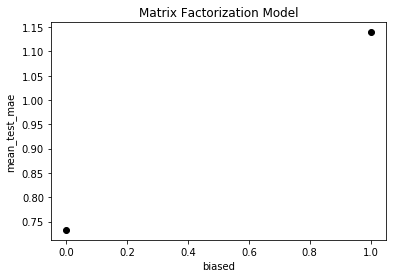

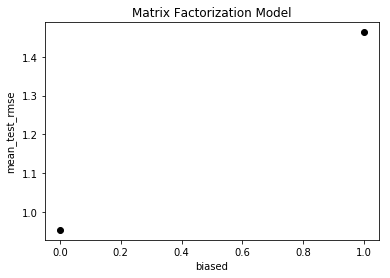

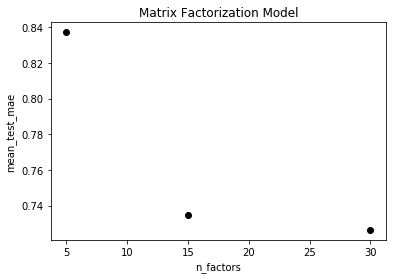

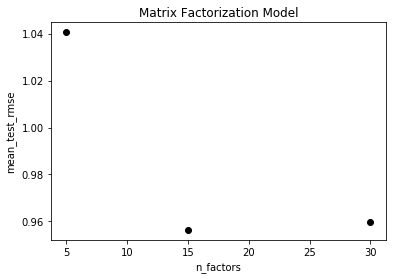

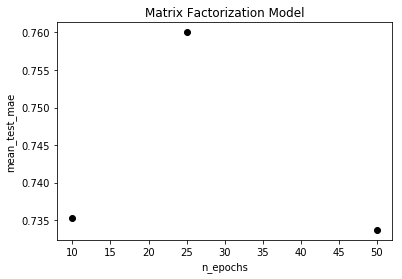

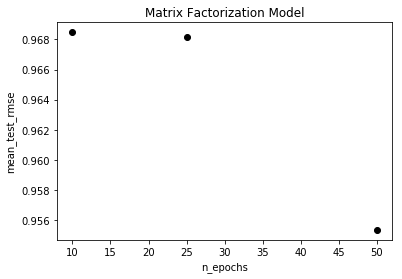

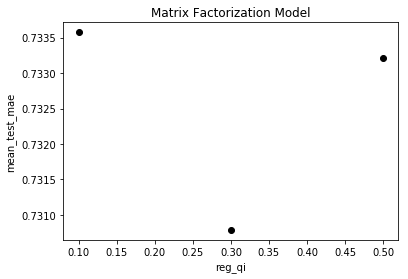

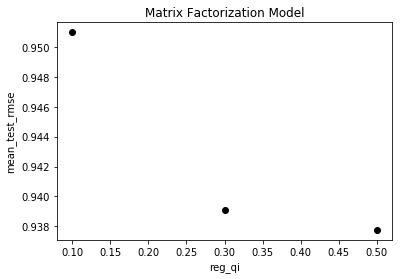

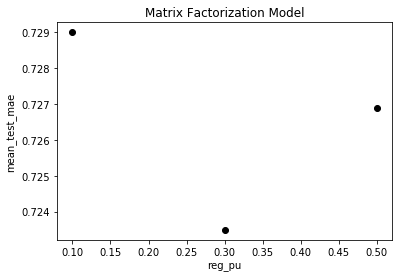

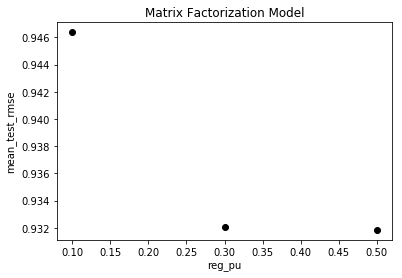

In [37]:
plotParameterResults(resultFiles)

**RESULTS**
    - Using an unbiased model gives better accuracy
    - As the number of factors increases, the accuracy metrics deacrease
    - For the regularization parameters, the RMSE decreases as they increase, but the MAE only descreases to a point before increasing with larger regularization values.

In [45]:
# TODO
# best RMSE score
print('The best RMSE is {}'.format(gridSearch_nmf.best_score['rmse']))

# combination of parameters that gave the best RMSE score
print('The best params are {}'.format(gridSearch_nmf.best_params['rmse']))

NameError: name 'gridSearch_nmf' is not defined

## Neighborhood Method

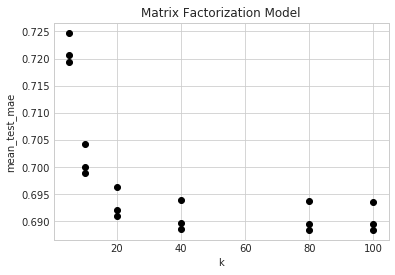

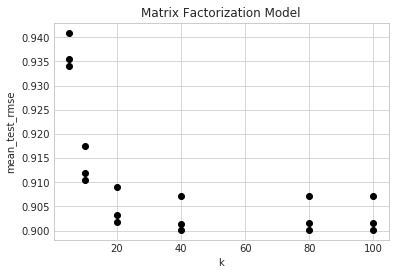

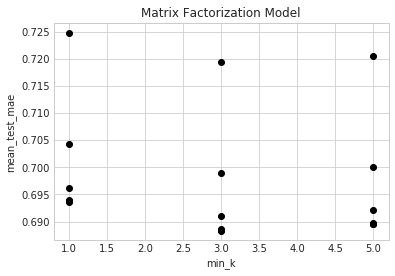

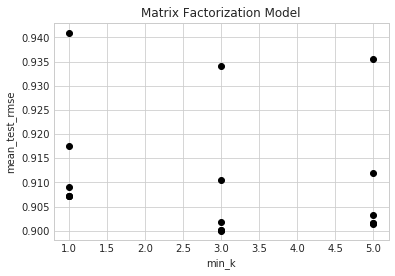

In [26]:
plotParameterResults(gridSearch_knn, paramGrid_knn)

In [27]:
gridSearch_knn.best_params

{'rmse': {'k': 40, 'min_k': 3, 'verbose': False},
 'mae': {'k': 100, 'min_k': 3, 'verbose': False}}

In [28]:
# best RMSE score
print('The best RMSE is {}'.format(gridSearch_knn.best_score['rmse']))

# combination of parameters that gave the best RMSE score
print('The best params are {}'.format(gridSearch_knn.best_params['rmse']))

The best RMSE is 0.9000430857076189
The best params are {'k': 40, 'min_k': 3, 'verbose': False}


## Tune Sample Size

In [41]:
# def plotSampleSizes(gridSearchFiles):
filename = "dataSizeResultsKNN.p"
resultList = resultFiles[filename]
timeKNN = [item['time'] for item in resultList]
rmseKNN = [item['rmse'] for item in resultList]
numRatingsKNN = [item['numRatings'] for item in resultList]

filename = "dataSizeResultsNMF.p"
resultList = resultFiles[filename]
timeNMF = [item['time'] for item in resultList]
rmseNMF = [item['rmse'] for item in resultList]
numRatingsNMF = [item['numRatings'] for item in resultList]
        

### NMF

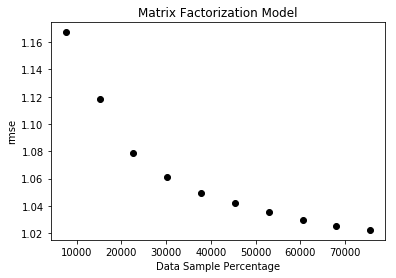

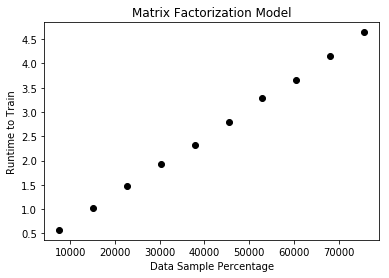

In [47]:
plt.plot(numRatingsNMF, rmseNMF, 'o', color='black')
plt.title('Matrix Factorization Model')
plt.xlabel('Data Sample Percentage')
plt.ylabel('rmse')
plt.show()
plt.close()

plt.plot(numRatingsNMF, timeNMF, 'o', color='black')
plt.title('Matrix Factorization Model')
plt.xlabel('Data Sample Percentage')
plt.ylabel('Runtime to Train')
plt.show()
plt.close()

### KNN

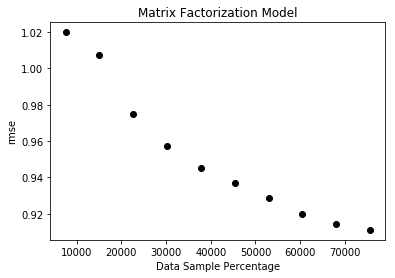

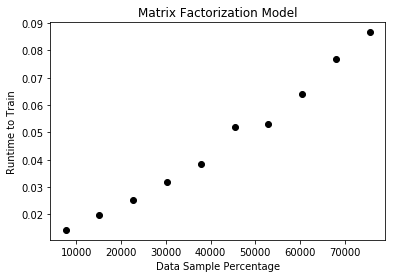

In [48]:
plt.plot(numRatingsKNN, rmseKNN, 'o', color='black')
plt.title('Matrix Factorization Model')
plt.xlabel('Data Sample Percentage')
plt.ylabel('rmse')
plt.show()
plt.close()

plt.plot(numRatingsKNN, timeKNN, 'o', color='black')
plt.title('Matrix Factorization Model')
plt.xlabel('Data Sample Percentage')
plt.ylabel('Runtime to Train')
plt.show()
plt.close()

**RESULTS**:

- For NMF, as you add more data, the RMSE exponentially decreases. Meanwhile, the runtime increases linearly as you add more data. This makes sense since more data will of course take longer to train. However, we can see that one of our choices in implimenting this model. At a certain point, adding data no longer changes the accuracy metric by much (for example, doubling the data from 10K to 20K makes a noticable difference, while doubling from 30K to 60K makes little difference). This shoudl be taken into account when deploying this model.
    - If the goal is to make the model quick to train, you could sacrifice soem accuracy for a large gain in runtime.

- A similar result is seen in the knn model. Again, it should be considered when deploying whether to sacrifice a small amount of accuracy for a gain in runtime.

## Conclusion